In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

from graph_gen import create_delegation_graph
import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


0
100
Mismatching powers in LP and Iterative. Check the log file for details.
200
Mismatching powers in LP and Iterative. Check the log file for details.
300
Mismatching powers in LP and Iterative. Check the log file for details.
400
Mismatching powers in LP and Iterative. Check the log file for details.
Average number of cycles:  0.8


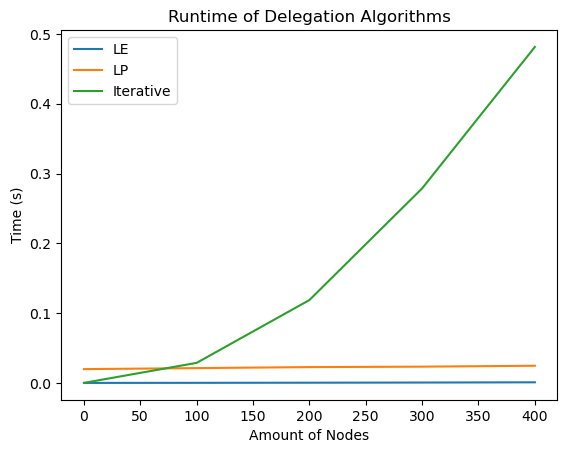

In [8]:
range_x = range(0, 500, 100)

time_data_le = []
time_data_lp = []
time_data_iterative = []
cycles = []


logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            big_loop = nx.DiGraph()
            # We're creating a graph with one node too many technically
            for i in range(num_nodes):
                if i == 0:
                    # Add split edge: 0.9 to the next node
                    big_loop.add_edge(i, (i + 1) % num_nodes, weight=0.5)
                    # Add the external node and edge with weight 0.1
                    big_loop.add_edge(i, num_nodes, weight=0.5)  # external node has index `n`
                else:
                    big_loop.add_edge(i, (i + 1) % num_nodes, weight=1.0)
                        
            big_loop = graph_tools.nx_graph_nodes_to_str(big_loop)
            delegations_orig = graph_tools.nx_graph_to_dict(big_loop)
            delegations = graph_tools.invert_graph(delegations_orig)
            nodes = list(big_loop)

            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break


        G = graph_tools.dict_to_nx_graph(delegations_orig)
        num_cycles = len(list(nx.simple_cycles(G)))
        cycles += [num_cycles]

        n = 50
        if 0 <= num_nodes < 500:
            n = 100

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

print("Average number of cycles: ", sum(cycles) / len(cycles))

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE")
    plt.plot(x, time_data_lp[i], label=f"LP") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

In [ ]:
# Random testing 
num_nodes = 0

big_loop = nx.DiGraph()
# We're creating a graph with one node too many technically
for i in range(num_nodes):
    if i == 0:
        # Add split edge: 0.9 to the next node
        big_loop.add_edge(i, (i + 1) % num_nodes, weight=0.9)
        # Add the external node and edge with weight 0.1
        big_loop.add_edge(i, num_nodes, weight=0.1)  # external node has index `n`
    else:
        big_loop.add_edge(i, (i + 1) % num_nodes, weight=1.0)

big_loop = graph_tools.nx_graph_nodes_to_str(big_loop)
delegations_orig = graph_tools.nx_graph_to_dict(big_loop)
delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(big_loop)

viz.visualize_delegation_graph(delegations_orig, powers={node: 0 for node in nodes})

No delegations to visualize.
